In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

# %matplotlib qt

In [2]:
steps, dist = np.genfromtxt('16x_microsteps_vs_distance_m.csv', delimiter=',', unpack=True, skip_header=1)
steps = steps[:len(steps)//2+1]
# convert to radians
rads = steps * 2. * np.pi / 3200. # 16x microstepping
dist = dist[:len(dist)//2+1]
errs = 0.005 * np.ones_like(dist) # assign blanket 5 mm errors. sensor estimated std <= 2mm, hand holding => 5 mm

In [3]:
def model_linear(rads, p):
    return p[0] * rads + p[1]

def model_spool(rads, p):
    return (p[1] / 2.) * (rads ** 2.) + p[0] * rads + p[2]

def residual(p, f, x, y, err):
    return (f(x, p) - y)

In [4]:
p0 = [.03, .03]
q0 = [.03, 1e-7, 0.03]

# popt, pcov = optimize.curve_fit(model_linear, rads, dist, p0, sigma=errs, absolute_sigma=True)
# slope, intc = popt
# punc = np.sqrt(np.diag(pcov))
# print(popt, pcov, np.sqrt(np.diag(pcov)))
pres = optimize.least_squares(residual, p0, args=(model_linear, rads, dist, errs))
pcov = np.linalg.inv(pres.jac.T.dot(pres.jac))
pvar = np.sqrt(np.diagonal(pcov))
chisqp = np.sum(pres.fun ** 2.)
dofp = len(rads) - len(p0)
print(pres.x, pvar, chisqp, dofp, chisqp / dofp)

# qopt, qcov = optimize.curve_fit(model_spool, rads, dist, q0, sigma=errs, absolute_sigma=True)
# rad, k, b = qopt
# qunc = np.sqrt(np.diag(qcov))
# print(qopt, qcov, np.sqrt(np.diag(qcov)))
qres = optimize.least_squares(residual, q0, args=(model_spool, rads, dist, errs))
qcov = np.linalg.inv(qres.jac.T.dot(qres.jac))
qvar = np.sqrt(np.diagonal(qcov))
chisqq = np.sum(qres.fun ** 2.)
dofq = len(rads) - len(q0)
print(qres.x, qvar, chisqq, dofq, chisqq/dofq)

[0.01603635 0.03696091] [0.01765666 0.38829014] 0.0006643547627130759 23 2.8884989683177214e-05
[ 1.71353577e-02 -5.83042378e-05  3.03433504e-02] [0.06818543 0.00349396 0.55500828] 0.00038589435477103033 22 1.754065248959229e-05


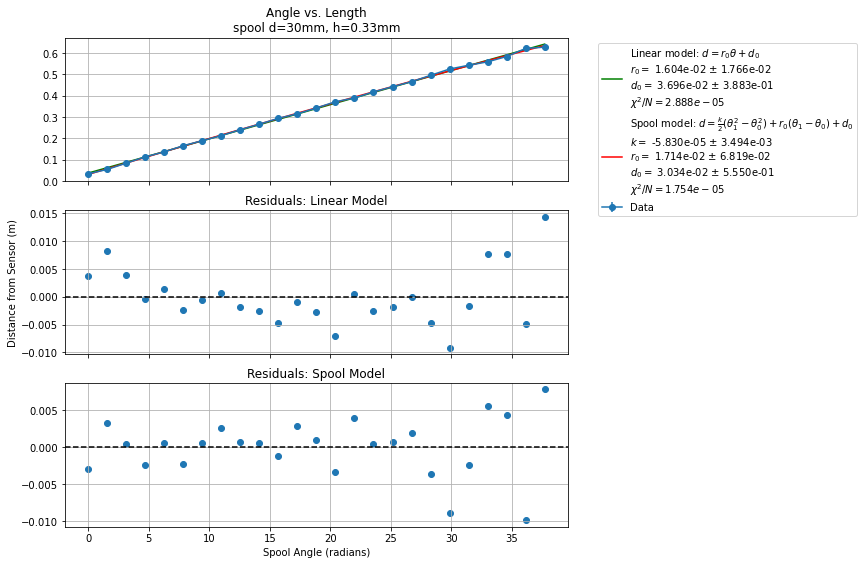

In [5]:
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(9,9))
axs[0].set_title('Angle vs. Length\nspool d=30mm, h=0.33mm')
axs[0].grid(True)
axs[0].errorbar(rads, dist, yerr=errs, marker='o', label='Data')
axs[0].plot(
    rads,
    model_linear(rads, pres.x),
    color='g',
    label='Linear model: $d = r_0 \\theta + d_0$\n'
    + '$r_0 =$ {:.3e} $\pm$ {:.3e}'.format(pres.x[0], pvar[0]) + '\n'
    + '$d_0 =$ {:.3e} $\pm$ {:.3e}'.format(pres.x[1], pvar[1]) + '\n'
    + '$\chi^2 / N = {:.3e}$'.format(chisqp / dofp)
)
axs[0].plot(
    rads,
    model_spool(rads, qres.x),
    color='r',
    label='Spool model: $d = \\frac{k}{2}(\\theta_1^2 - \\theta_0^2) + r_0 (\\theta_1 - \\theta_0) + d_0$\n'
    + '$k =$ {:.3e} $\pm$ {:.3e}'.format(qres.x[1], qvar[1]) + '\n'
    + '$r_0 =$ {:.3e} $\pm$ {:.3e}'.format(qres.x[0], qvar[0]) + '\n'
    + '$d_0 =$ {:.3e} $\pm$ {:.3e}'.format(qres.x[2], qvar[2]) + '\n'
    + '$\chi^2 / N = {:.3e}$'.format(chisqq / dofq)
)
axs[0].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

axs[1].set_title('Residuals: Linear Model')
axs[1].grid(True)
axs[1].scatter(rads, pres.fun)
axs[1].axhline(y=0, xmin=np.min(rads), xmax=np.max(rads), color='k', linestyle='--')
axs[1].set_ylabel('Distance from Sensor (m)')
# axs[1].set_xabel

axs[2].set_title('Residuals: Spool Model')
axs[2].grid(True)
axs[2].scatter(rads, qres.fun)
axs[2].axhline(y=0, xmin=np.min(rads), xmax=np.max(rads), color='k', linestyle='--')
axs[2].set_xlabel('Spool Angle (radians)')

plt.show()